# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
#import scienceplots
import seaborn
#plt.style.use(['science', 'notebook'])
plt.style.use("seaborn-v0_8-paper")
import numpy as np

import torch
from sklearn import datasets, decomposition

In [ ]:
from polcanet import PolcaNet, LinearDecoder
from polcanet.example_aencoders import autoencoder_factory, generate_2d_sinusoidal_data, StandardScalerTorch, MinMaxScalerTorch

In [346]:
from polcanet.polcanet_reports import analyze_latent_space, show_correlation_matrix, plot_scatter_corr_matrix, plot_stdev_pct, \
    plot_cumsum_variance, analyze_latent_feature_importance, analyze_reconstruction_error, orthogonality_test_analysis, \
    variance_test_analysis, linearity_tests_analysis

In [4]:
np.random.seed(5)

In [5]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load iris dataset

In [6]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X.shape,X[0].shape

((150, 4), (4,))

### Fit standard sklearn PCA

In [7]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

### Fit POLCANet

In [328]:
ae_input = X
act_fn = torch.nn.Mish()

encoder_iris = autoencoder_factory(
    input_dim=ae_input.shape[1],
    latent_dim=ae_input.shape[1],
    hidden_dim=512,
    num_layers=10,
    autoencoder_type="dense",
    act_fn=act_fn,
)

decoder_iris = LinearDecoder(latent_dim=ae_input.shape[1],
                             output_shape=X[0].shape, 
                             hidden_dim=64, 
                             num_layers=3)


model_iris = PolcaNet(
    encoder=encoder_iris,
    decoder=decoder_iris,
    latent_dim = ae_input.shape[1],
    alpha=0.01,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    scaler = StandardScalerTorch(),
)
model_iris

PolcaNet(
  (encoder): BaseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=512, bias=True)
      (1): Mish()
      (2): ResNet(
        (module): Linear(in_features=512, out_features=512, bias=True)
      )
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (4): Mish()
      (5): ResNet(
        (module): Linear(in_features=512, out_features=512, bias=True)
      )
      (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (7): Mish()
      (8): ResNet(
        (module): Linear(in_features=512, out_features=512, bias=True)
      )
      (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (10): Mish()
      (11): ResNet(
        (module): Linear(in_features=512, out_features=512, bias=True)
      )
      (12): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (13): Mish()
      (14): ResNet(
        (module): Linear(in_features=512, out_features=512, bias=True)
      )
      (15): LayerNorm((512

In [329]:
model_iris.to("cuda")
model_iris.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.04789
Reconstruction Loss: 0.0004748
Orthogonality Loss: 0.4824
Center of Mass Loss: 0.02284
Variance Distribution Loss: 0.01975


In [330]:
model_iris.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.04724
Reconstruction Loss: 2.511e-05
Orthogonality Loss: 0.4822
Center of Mass Loss: 0.02191
Variance Distribution Loss: 0.02049


## Evaluate results

In [331]:
latents, reconstructed = model_iris.predict(X)

In [332]:
analyze_latent_space(model_iris, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 4
Total variance in latent space: 115.8080

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.6513
First 5 components              1
Components for 95% variance     2
Variance Concentration Metric   0.9127

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0298
Median absolute off-diagonal          0.0048
Max absolute off-diagonal             0.1555
Proportion of |Orthogonality| > 0.1   0.1667
Orthogonality Success Metric          0.9702

Orthogonality Interpretation:
Excellent orthogonality of features.

4. 

/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


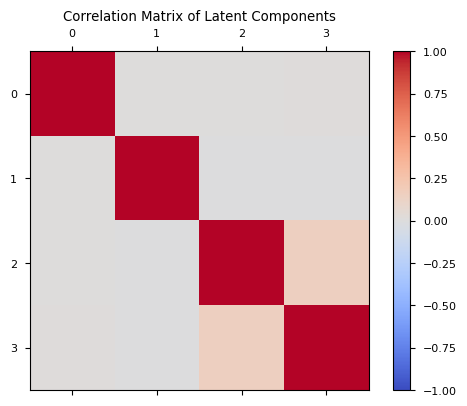

In [333]:
show_correlation_matrix(model_iris,latents)

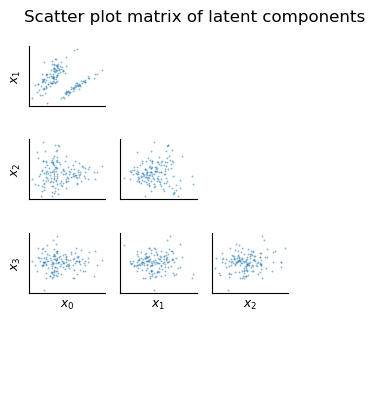

In [334]:
plot_scatter_corr_matrix(model_iris,latents)

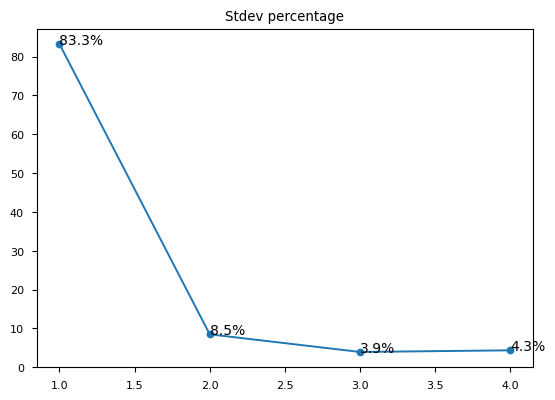

In [335]:
plot_stdev_pct(model_iris)

(1) reconstruction error: 1.3400, variance: 100.0%, with      1  active latent components
(2) reconstruction error: 0.5890, variance: 100.0%, with      2  active latent components
(3) reconstruction error: 0.7729, variance: 100.0%, with      3  active latent components
(4) reconstruction error: 0.0000, variance: 100.0%, with      4  active latent components


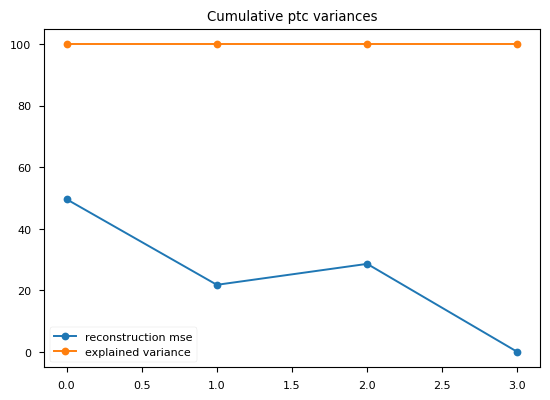

In [336]:
plot_cumsum_variance(model_iris,X)

### Polca Net vs. PCA

In [337]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.scatter(X[y == label, 0], X[y == label, 1], label=name)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [338]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _,_ = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _,_ = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [339]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y, "Original data two first componets", legend=False)

with o2:
    fig2, ax2 = plot2d_analysis(pca.inverse_transform(Xpca), y, "Reconstructed with PCA two componets", legend=False)

with o3:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 0, 0]))
    fig3, ax3 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA two componets", legend=False)

with o4:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 1, 1]))
    fig4, ax4 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA all componets", legend=False)


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

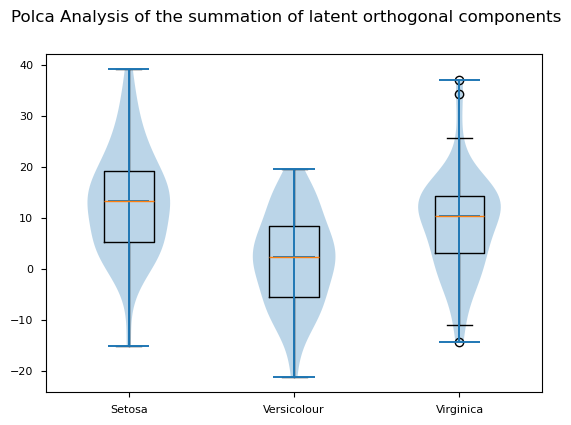

In [340]:
latents, reconstructed = model_iris.predict(X)
vectors = []
labels = ["Setosa", "Versicolour", "Virginica"]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [341]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model_iris.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last componet with clean data")
    plt.show()

with o2:
    scores = model_iris.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [342]:
model_iris.std_metrics

array([3.689037  , 0.37511358, 0.1738491 , 0.19255838], dtype=float32)

In [343]:
model_iris.mean_metrics

array([-5.003949 , -7.369082 ,  1.3650703,  3.7880697], dtype=float32)

In [217]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape

(1000, 32, 32)

In [302]:
encoder_lstm = autoencoder_factory(
    input_dim=M,
    latent_dim=256,
    hidden_dim=None,
    num_layers=2,
    autoencoder_type="lstm",
    seq_len=N,
    act_fn=act_fn,
)

decoder_lstm = LinearDecoder(latent_dim=256,
                             output_shape=data.shape[1:], 
                             hidden_dim=256, 
                             num_layers=3)


model_lstm = PolcaNet(
    encoder=encoder_lstm,
    decoder=decoder_lstm,
    latent_dim = 256,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    scaler = StandardScalerTorch(),
)
model_lstm

PolcaNet(
  (encoder): LSTMAutoencoder(
    (encoder): LSTMEncoder(
      (lstm): LSTM(32, 256, num_layers=2, batch_first=True)
    )
    (decoder): None
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
)

In [ ]:
model_lstm.to_device("cuda")
model_lstm.train_model(data=data, batch_size=512, num_epochs=20000, report_freq=10, lr=0.001)

In [308]:
model_lstm.to_device("cuda")
model_lstm.train_model(data=data, batch_size=512, num_epochs=1000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.002063
Reconstruction Loss: 2.085e-05
Orthogonality Loss: 0.01795
Center of Mass Loss: 0.0002014
Variance Distribution Loss: 4.581e-05


In [313]:
latents, reconstructed = model_lstm.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

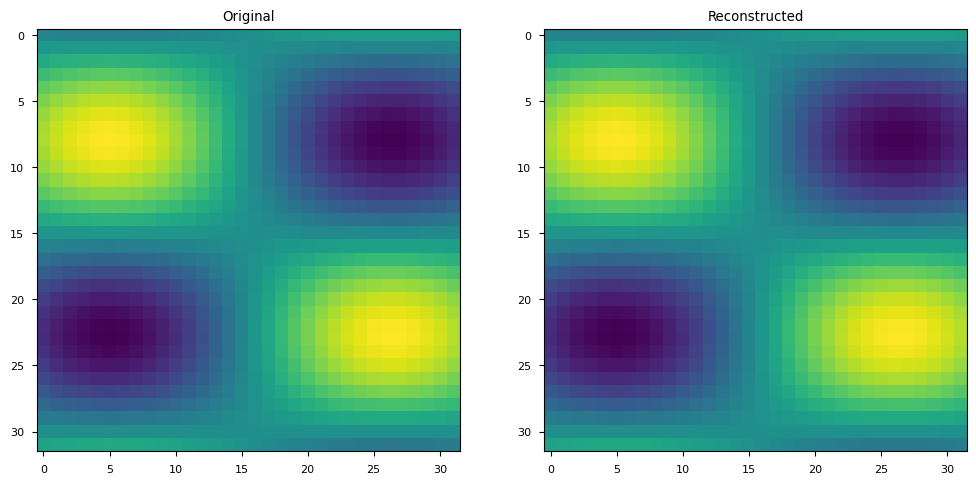

In [314]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

In [315]:
analyze_latent_space(model_lstm, data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 0.2770

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.3229
First 5 components              0.9745
Components for 95% variance     5
Variance Concentration Metric   0.9937

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0615
Median absolute off-diagonal          0.0347
Max absolute off-diagonal             0.9799
Proportion of |Orthogonality| > 0.1   0.201
Orthogonality Success Metric          0.9385

Orthogonality Interpretation:
Excellent orthogonality of features.



    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0002
    - Max cosine similarity: 0.9812
    - Min cosine similarity: -0.9666
    


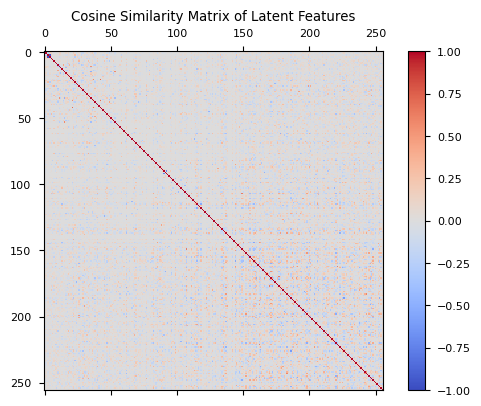

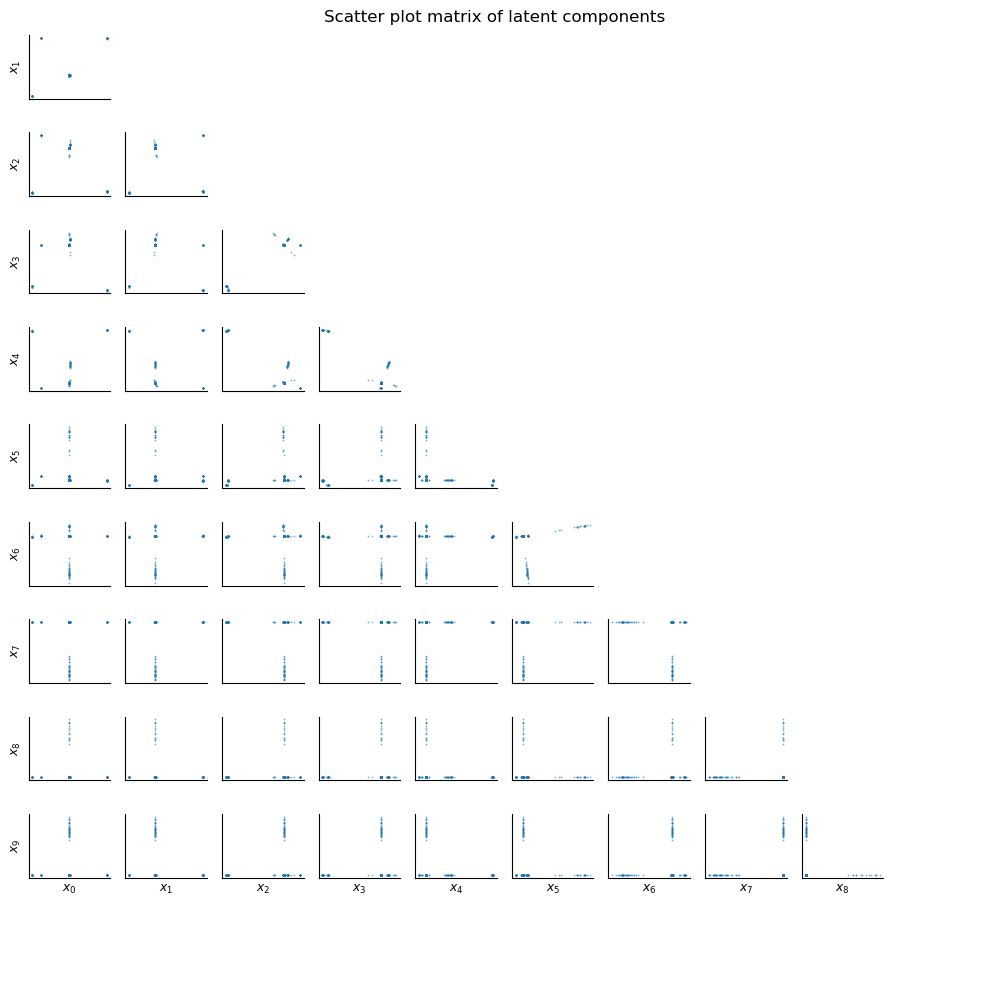

In [316]:
orthogonality_test_analysis(model_lstm, data)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.6108
    - Variance fit to exponential distribution (sum of squared differences):
     0.1232
    


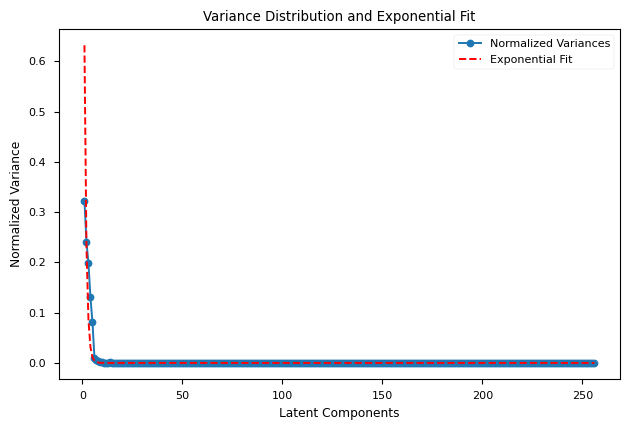

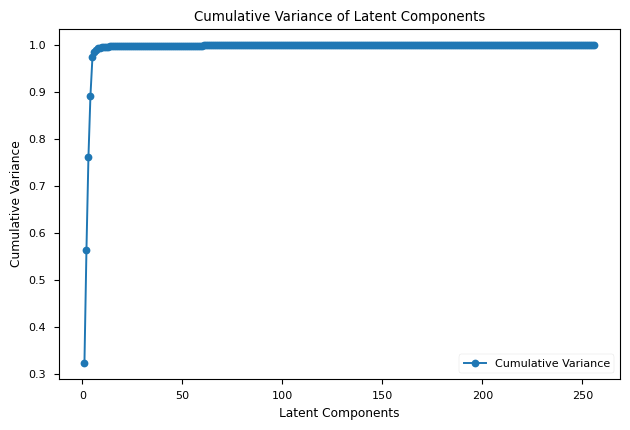

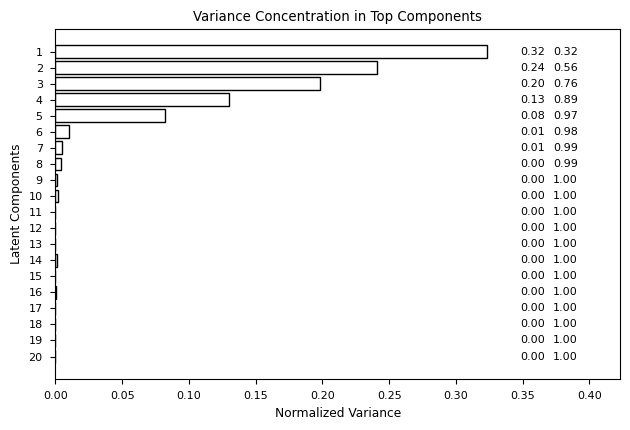

In [317]:
variance_test_analysis(model_lstm, data)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of 
    100 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property 
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.0447
    - Max difference: 0.1308
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.0055

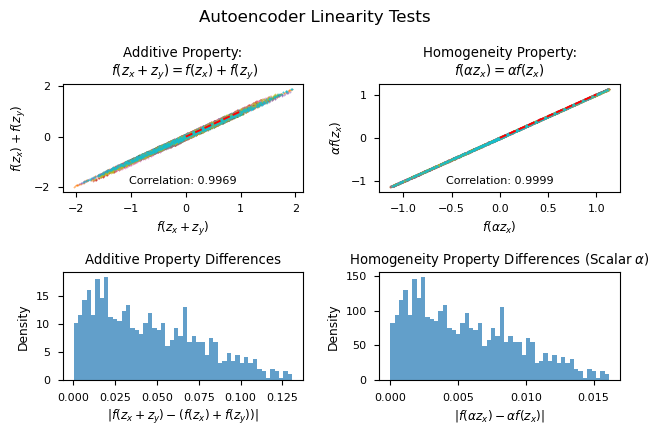

In [318]:
linearity_tests_analysis(model_lstm, data)

In [ ]:
latent_dim = 64
encoder_conv = autoencoder_factory(
    input_dim=M,
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    seq_len=N,
)


decoder_conv = LinearDecoder(latent_dim=latent_dim*4,
                             output_shape=data.shape[1:], 
                             hidden_dim=256, 
                             num_layers=3)


model_conv = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim = latent_dim*4,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    scaler = StandardScalerTorch(),
)
model

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Mish()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Mish()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): Mish()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): Mish()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (decoder): None
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
)

In [305]:
model_conv.to("cuda")
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.003958
Reconstruction Loss: 0.0003893
Orthogonality Loss: 0.03161
Center of Mass Loss: 0.0003305
Variance Distribution Loss: 7.725e-05


In [306]:
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.002994
Reconstruction Loss: 7.293e-05
Orthogonality Loss: 0.0275
Center of Mass Loss: 0.0001195
Variance Distribution Loss: 5.07e-05


In [282]:
latents, reconstructed = model_conv.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

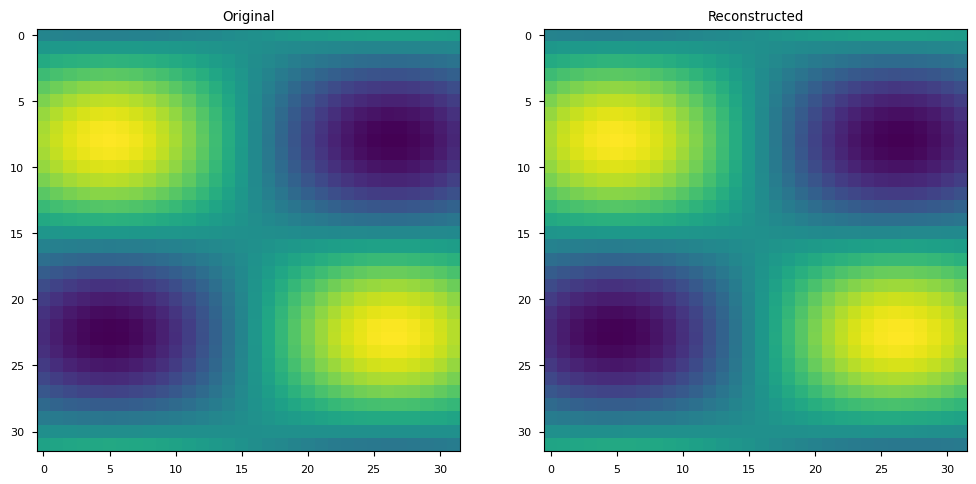

In [288]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

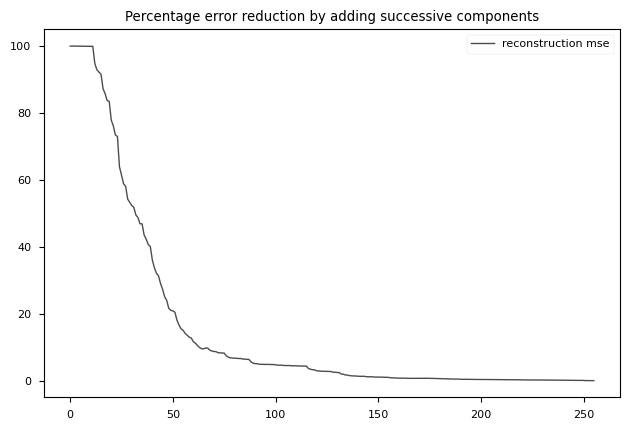

In [350]:
plot_cumsum_variance(model, data)

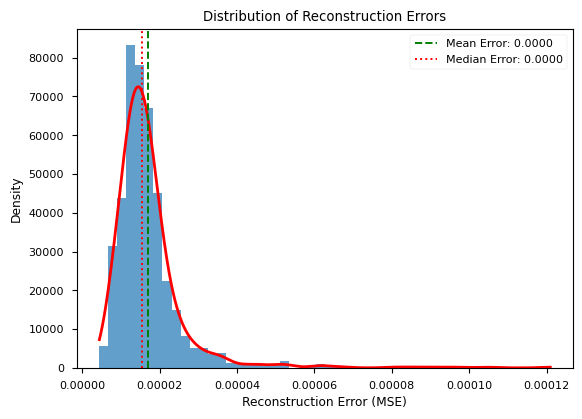

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0001


In [296]:
analyze_reconstruction_error(model_conv, data, n_samples=10000)

In [297]:
analyze_latent_space(model_conv, data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 4534.6992

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4125
First 5 components              0.9901
Components for 95% variance     4
Variance Concentration Metric   0.9957

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0592
Median absolute off-diagonal          0.0445
Max absolute off-diagonal             0.9047
Proportion of |Orthogonality| > 0.1   0.1642
Orthogonality Success Metric          0.9408

Orthogonality Interpretation:
Excellent orthogonality of featur


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0035
    - Max cosine similarity: 0.9057
    - Min cosine similarity: -0.6425
    


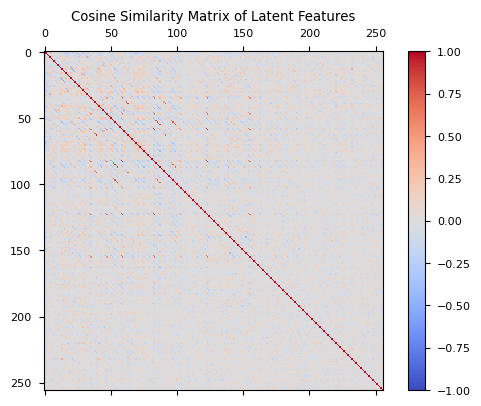

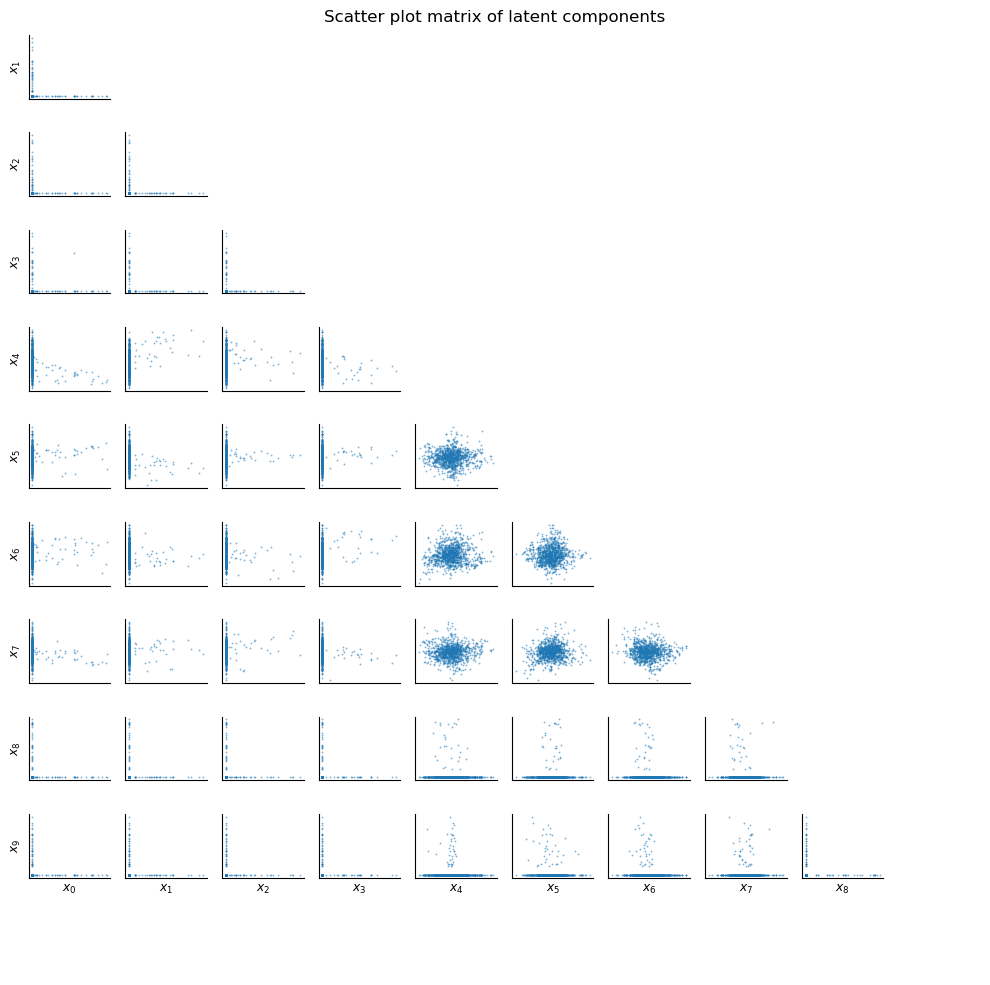

In [298]:
orthogonality_test_analysis(model_conv, data)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.1047
    - Variance fit to exponential distribution (sum of squared differences):
     0.0670
    


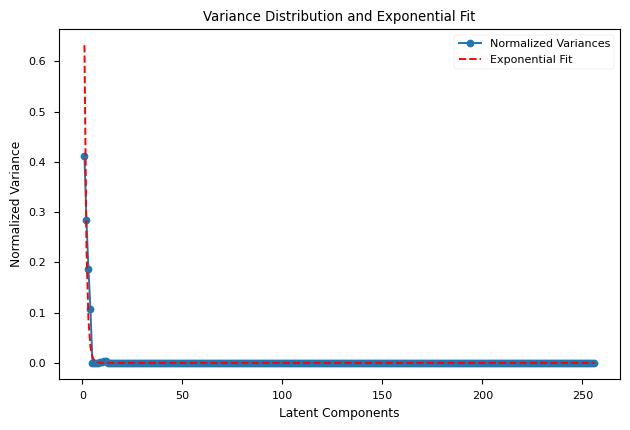

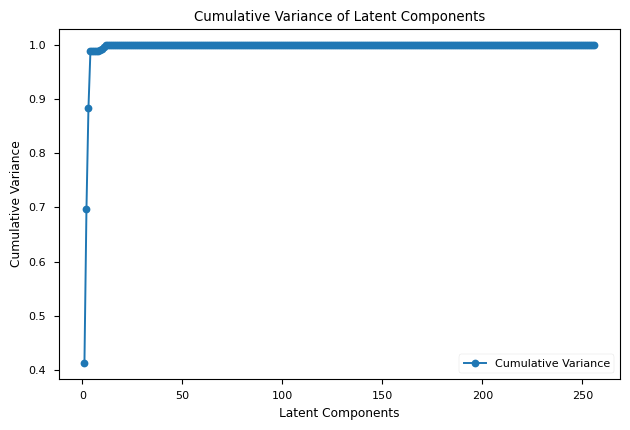

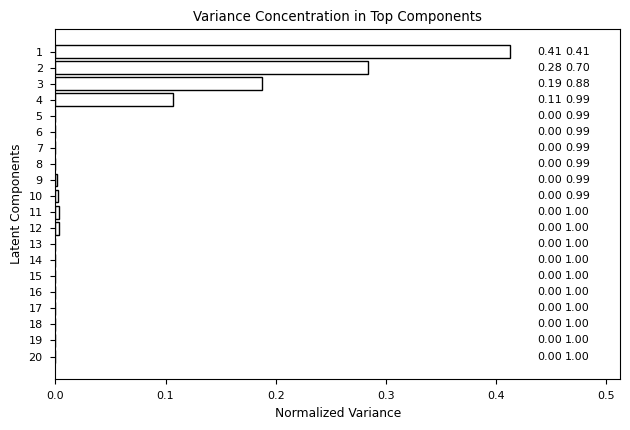

In [299]:
variance_test_analysis(model_conv, data)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of 
    100 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property 
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.0243
    - Max difference: 0.0714
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.0110

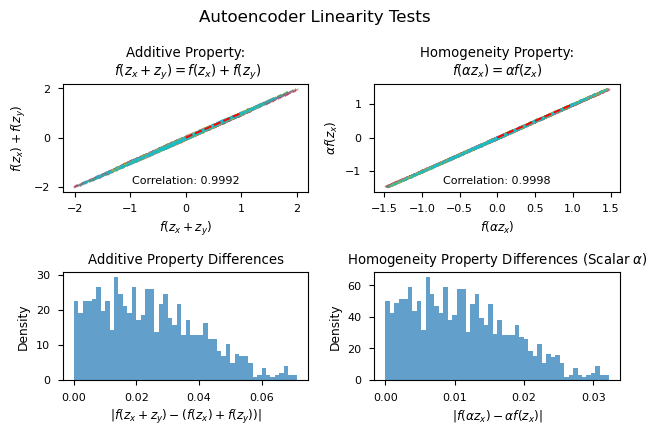

In [300]:
linearity_tests_analysis(model_conv, data)

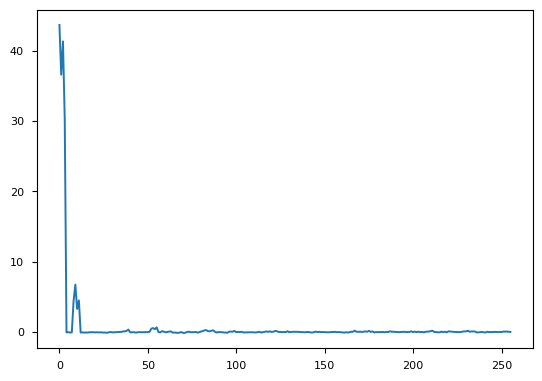

In [301]:
plt.plot(model_conv.mean_metrics)